In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample 

In [11]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [12]:
data = pd.read_csv("../data/dataset_2019_with_negatives.csv")

In [13]:
data = data.drop(columns=['year', 'precipAccumulation'])

In [14]:
boroughs = pd.read_csv("../data/localidades.csv")

In [15]:
data = data.merge(boroughs[['id', 'borough']], left_on='borough', right_on='borough')
data.rename(columns={"id": 'borough_id'}, inplace=True)
data.head(25)

,x,y,timestamp,date,day_of_year,month,day,hour,address,severity,...,windSpeed,windBearing,cloudCover,uvIndex,visibility,pressure,windGust,precipType,ozone,borough_id
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,11,1,11,14,KR 26-CL 52B S 2,Injury,...,1.66,167.0,0.89,4.0,13.489,1018.0,1.66,rain,239.8,6
1,-74.139488,4.573233,2019-01-11 14:00:00,2019-01-11,11,1,11,14,AV AVENIDA BOYACA-KR 24 2,NaN,...,1.66,167.0,0.89,4.0,13.489,1018.0,1.66,rain,239.8,6
2,-74.135804,4.588874,2019-01-11 17:38:00,2019-01-11,11,1,11,17,CL 49A-KR 37 S 2,Injury,...,1.90,225.0,0.95,7.0,12.000,1016.3,2.17,rain,237.6,6
3,-74.123576,4.558440,2019-01-11 17:00:00,2019-01-11,11,1,11,17,CL 52-KR 10A S 2,NaN,...,1.90,225.0,0.95,7.0,12.000,1016.3,2.17,rain,237.6,6
4,-74.138016,4.566990,2019-01-24 12:00:00,2019-01-24,24,1,24,12,AV AVENIDA BOYACA-KR 19C 2,Injury,...,3.37,129.0,0.67,0.0,15.142,1016.2,5.20,rain,240.4,6
5,-74.139201,4.589385,2019-01-24 12:00:00,2019-01-24,24,1,24,12,TR 44-CL 51A S 02,NaN,...,3.37,129.0,0.67,0.0,15.142,1016.2,5.20,rain,240.4,6
6,-74.142594,4.580252,2019-04-24 14:30:00,2019-04-24,114,4,24,14,AV AVENIDA JORGE GAITAN CORTES-AV AVENIDA BOYA...,Material damage,...,1.50,77.0,0.99,5.0,2.976,1019.3,2.30,rain,249.9,6
7,-74.129479,4.564287,2019-08-13 19:30:00,2019-08-13,225,8,13,19,CL 55-KR 15 S 02,Injury,...,3.05,140.0,0.94,6.0,9.508,1013.8,4.19,rain,255.8,6
8,-74.140921,4.577249,2019-08-19 08:38:00,2019-08-19,231,8,19,8,CL 56A-KR 27 S 2,Injury,...,2.02,112.0,0.75,0.0,16.093,1018.2,3.09,rain,257.8,6
9,-74.130654,4.576701,2019-08-02 20:20:00,2019-08-02,214,8,2,20,CL 48C-KR 23F S 2,Injury,...,2.41,152.0,0.88,5.0,10.306,1012.0,3.02,rain,255.0,6


In [21]:
data = pd.get_dummies(data, columns=['summary'])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174354 entries, 0 to 174353
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   x                            174354 non-null  float64
 1   y                            174354 non-null  float64
 2   timestamp                    174354 non-null  object 
 3   date                         174354 non-null  object 
 4   day_of_year                  174354 non-null  int64  
 5   month                        174354 non-null  int64  
 6   day                          174354 non-null  int64  
 7   hour                         174354 non-null  int64  
 8   address                      174354 non-null  object 
 9   severity                     29053 non-null   object 
 10  accident_type                29053 non-null   object 
 11  severity_numeric             29053 non-null   float64
 12  borough                      174354 non-null  object 
 13 

In [23]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

apparentTemperature          temperature                    0.998
temperature                  apparentTemperature            0.998
day_of_year                  month                          0.996
month                        day_of_year                    0.996
temperature                  uvIndex                        0.835
uvIndex                      temperature                    0.835
windSpeed                    windGust                       0.828
windGust                     windSpeed                      0.828
apparentTemperature          uvIndex                        0.826
uvIndex                      apparentTemperature            0.826
precipProbability            precipIntensity                0.786
precipIntensity              precipProbability              0.786
hour                         temperature                    0.698
temperature                  hour                           0.698
apparentTemperature          hour                           0.691
hour      

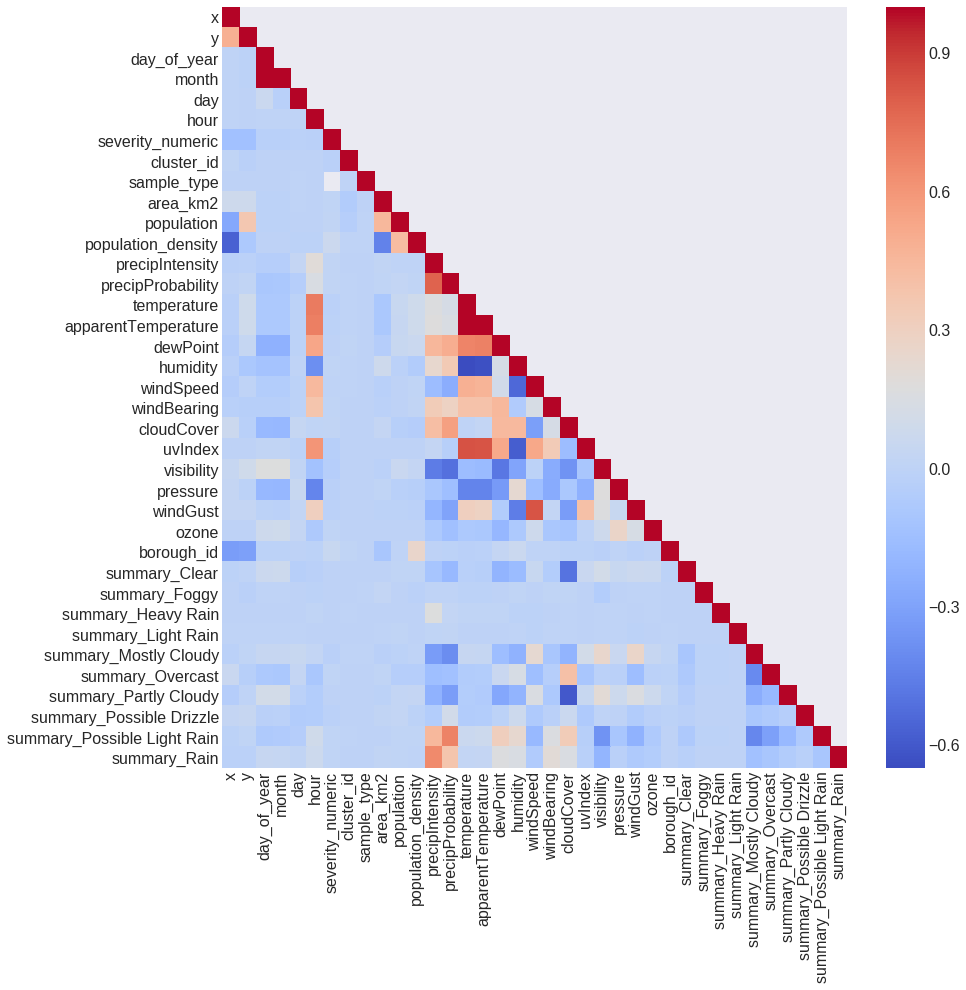

In [24]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

In [25]:
corr.columns

Index(['x', 'y', 'day_of_year', 'month', 'day', 'hour', 'severity_numeric',
       'cluster_id', 'sample_type', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain'],
      dtype='object')

In [55]:
feature_columns_model_1 = ['x', 'y', 'month', 'day', 'day_of_year', 'hour',
       'cluster_id', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain']
X = data[feature_columns_model_1]
y = data.sample_type

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## First model. All Variables. Unbalanced Classes

In [63]:
from sklearn.naive_bayes import GaussianNB
categories = ['non-accident', 'accident']
clf1 = GaussianNB()
clf1.fit(X_train, y_train)
scores = cross_val_score(clf1, X_train, y_train, cv=5, scoring= 'f1_weighted', n_jobs=-1)
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.76 (+/- 0.000 )


In [60]:
y_pred = clf1.predict(X_test)
print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test)))
print(classification_report(y_test, y_pred, target_names=categories))

Cohen kappa score 0.00
              precision    recall  f1-score   support

non-accident       0.83      1.00      0.91     47821
    accident       0.00      0.00      0.00      9716

    accuracy                           0.83     57537
   macro avg       0.42      0.50      0.45     57537
weighted avg       0.69      0.83      0.75     57537



In [65]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
for metric in metric_names:
    score1 = cross_val_score(clf1, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf1, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]

In [66]:
scores_df

,Random-CV,Stratified-CV
f1,0,0
roc_auc,0.495552,0.494235
average_precision,0.163823,0.163392
accuracy,0.834468,0.834468
precision,0,0
recall,0,0


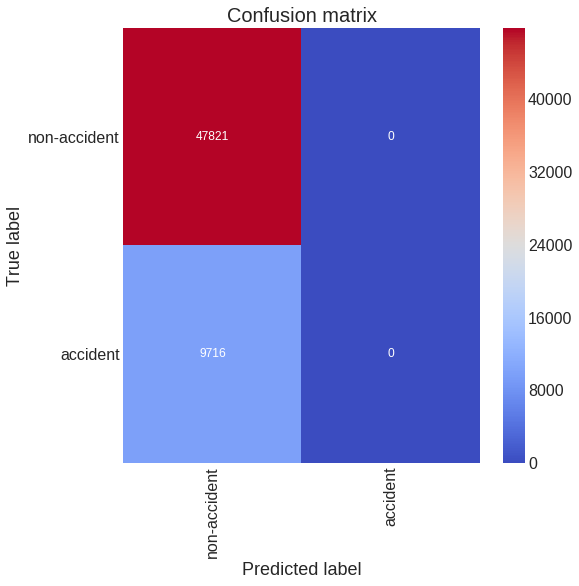

In [67]:
cnf_mx = confusion_matrix(y_test,y_pred, labels=[0,1])
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix', fontsize=20)
plt.show()

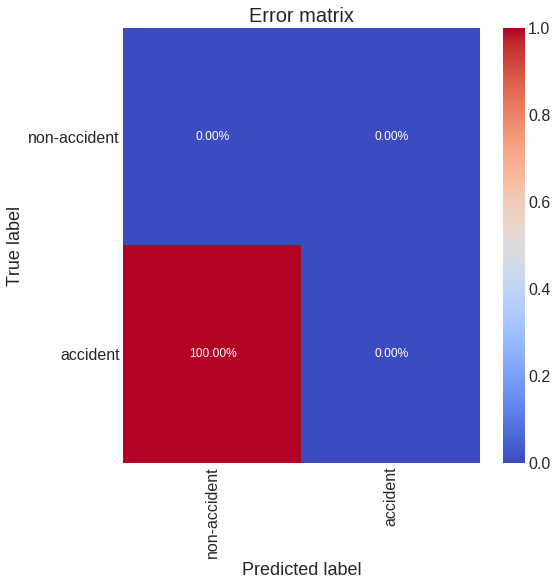

In [69]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".2%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## First model

###  All variables. Balanced Classes

In [70]:
# Separate majority and minority classes
df_majority = data[data.sample_type==0]
df_minority = data[data.sample_type==1]
print(df_majority.shape, df_minority.shape)

(145301, 46) (29053, 46)


In [71]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=29053*5)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.sample_type.value_counts()

0    145301
1    145265
Name: sample_type, dtype: int64

In [72]:
X = df_upsampled[feature_columns_model_1]
y = df_upsampled.sample_type

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [74]:
categories = ['accident', 'non-accident']
clf2 = GaussianNB()
clf2.fit(X_train, y_train)
scores = cross_val_score(clf2, X_train, y_train, cv=10, scoring= 'f1_weighted', n_jobs=-1)
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.50 (+/- 0.006 )


In [75]:
y_pred = clf2.predict(X_test)
print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test)))
print(classification_report(y_test, y_pred,target_names=categories))

Cohen kappa score 0.01
              precision    recall  f1-score   support

    accident       0.50      0.51      0.51     47896
non-accident       0.50      0.49      0.50     47991

    accuracy                           0.50     95887
   macro avg       0.50      0.50      0.50     95887
weighted avg       0.50      0.50      0.50     95887



In [78]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
for metric in metric_names:
    score1 = cross_val_score(clf2, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf2, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]

In [79]:
scores_df

,Random-CV,Stratified-CV
f1,0.494833,0.494917
roc_auc,0.502916,0.502853
average_precision,0.501086,0.50109
accuracy,0.502633,0.503121
precision,0.502505,0.502881
recall,0.488286,0.487458


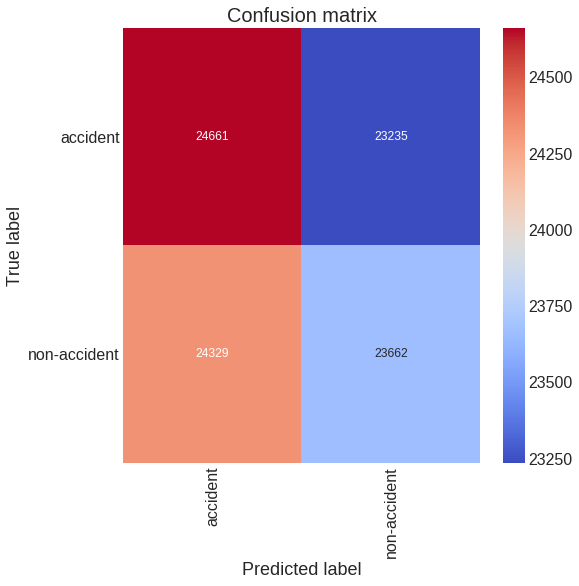

In [82]:
cnf_mx = confusion_matrix(y_test,y_pred,labels=[0,1])
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

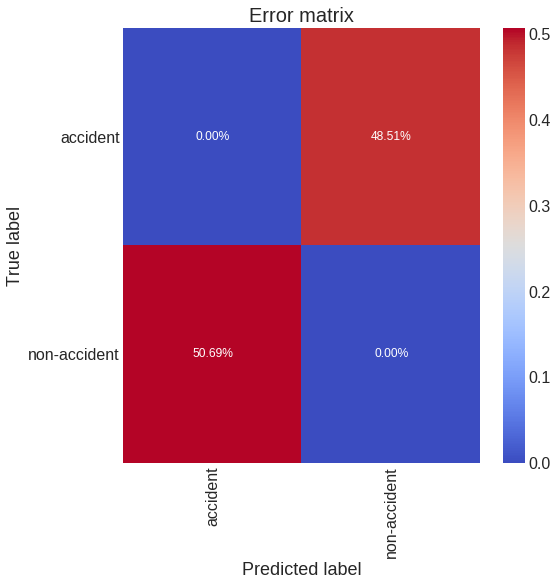

In [84]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".2%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [85]:
from sklearn import metrics

def roc_curve(y_pred_proba, targets, model_name=""):
    fpr, tpr, _ = metrics.roc_curve(targets,  y_pred_proba)
    auc = metrics.roc_auc_score(targets, y_pred_proba)
    
    # Display plot for AUC curve
    plt.figure(figsize=(14,10))
    plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,3)}")
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}")
    plt.show()
    
    return round(auc,4)

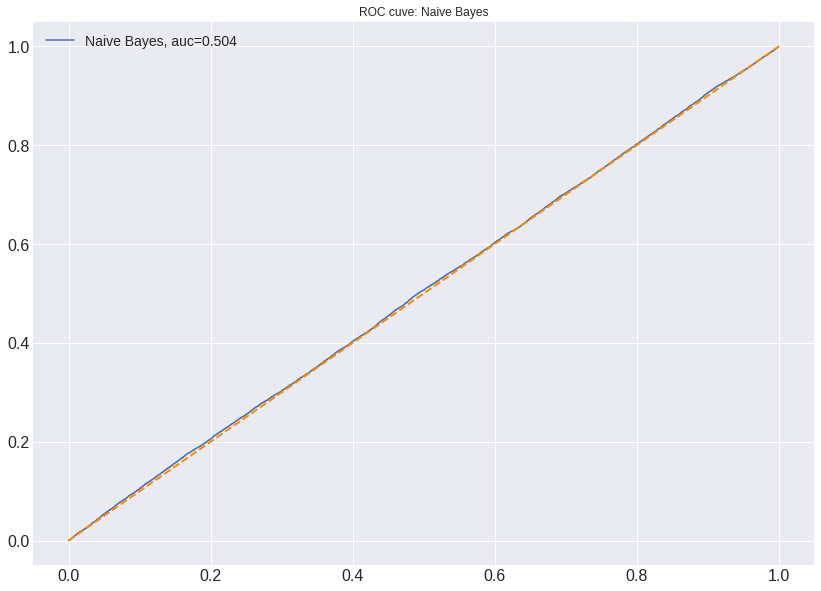

0.5035

In [86]:
roc_curve(clf2.predict_proba(X_test)[:,1], y_test, "Naive Bayes")

## Second model

###  Numeric weather Covariates. Balanced classes

In [87]:
corr.columns

Index(['x', 'y', 'day_of_year', 'month', 'day', 'hour', 'severity_numeric',
       'cluster_id', 'sample_type', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain'],
      dtype='object')

In [88]:
feature_selection_1 = data[['x', 'y', 'day_of_year', 'hour',
       'cluster_id','population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'dewPoint', 'humidity','windSpeed', 
       'cloudCover', 'visibility', 'pressure', 'borough_id', 'sample_type']]

In [89]:
feature_selection_1['precipitation_probability_intesity'] = feature_selection_1['precipIntensity'] * feature_selection_1['precipProbability']

In [90]:
feature_selection_1

,x,y,day_of_year,hour,cluster_id,population_density,precipIntensity,precipProbability,temperature,dewPoint,humidity,windSpeed,cloudCover,visibility,pressure,borough_id,sample_type,precipitation_probability_intesity
0,-74.134363,4.579297,11,14,-1,20124.11,0.3083,0.22,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,1,0.067826
1,-74.139488,4.573233,11,14,586,20124.11,0.3083,0.22,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,0,0.067826
2,-74.135804,4.588874,11,17,-1,20124.11,1.6823,0.35,14.98,13.98,0.94,1.90,0.95,12.000,1016.3,6,1,0.588805
3,-74.123576,4.558440,11,17,275,20124.11,1.6823,0.35,14.98,13.98,0.94,1.90,0.95,12.000,1016.3,6,0,0.588805
4,-74.138016,4.566990,24,12,33,20124.11,0.1040,0.08,11.85,10.06,0.89,3.37,0.67,15.142,1016.2,6,1,0.008320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174349,-74.364048,3.985513,5,13,-1,8.36,0.0906,0.08,5.69,4.32,0.91,3.04,0.44,13.723,1019.8,20,0,0.007248
174350,-74.364048,3.985513,232,13,-1,8.36,0.2862,0.12,5.61,5.39,0.98,2.17,0.75,6.701,1020.7,20,0,0.034344
174351,-74.364001,3.985578,149,6,-1,8.36,0.5873,0.17,6.03,6.03,1.00,1.64,0.99,7.132,1018.0,20,0,0.099841
174352,-74.364001,3.985578,212,6,-1,8.36,0.0072,0.08,3.99,3.62,0.97,2.47,0.46,16.093,1018.9,20,0,0.000576


In [91]:
feature_selection_1 = feature_selection_1.drop(columns=['precipIntensity', 'precipProbability'])

In [92]:
feature_selection_1.head(2)

,x,y,day_of_year,hour,cluster_id,population_density,temperature,dewPoint,humidity,windSpeed,cloudCover,visibility,pressure,borough_id,sample_type,precipitation_probability_intesity
0,-74.134363,4.579297,11,14,-1,20124.11,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,1,0.067826
1,-74.139488,4.573233,11,14,586,20124.11,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,0,0.067826


In [93]:
# Separate majority and minority classes
df_majority_fs_1 = feature_selection_1[feature_selection_1.sample_type==0]
df_minority_fs1 = feature_selection_1[feature_selection_1.sample_type==1]
print(df_majority_fs_1.shape, df_minority_fs1.shape)

(145301, 16) (29053, 16)


In [94]:
# Upsample minority class
df_minority_upsampled_fs1 = resample(df_minority_fs1, replace=True, n_samples=29053*5)
 
# Combine majority class with upsampled minority class
df_upsampled_fs1 = pd.concat([df_majority_fs_1, df_minority_upsampled_fs1])
 
# Display new class counts
df_upsampled_fs1.sample_type.value_counts()

0    145301
1    145265
Name: sample_type, dtype: int64

In [95]:
df_majority_fs_1.columns

Index(['x', 'y', 'day_of_year', 'hour', 'cluster_id', 'population_density',
       'temperature', 'dewPoint', 'humidity', 'windSpeed', 'cloudCover',
       'visibility', 'pressure', 'borough_id', 'sample_type',
       'precipitation_probability_intesity'],
      dtype='object')

In [98]:
feature_columns_model_2 = ['x', 'y', 'day_of_year', 'hour', 'cluster_id',
                            'population_density', 'temperature', 'dewPoint', 'humidity',
                            'windSpeed', 'cloudCover', 'visibility', 'pressure',
                            'borough_id', 'precipitation_probability_intesity']

In [99]:
X = df_upsampled_fs1[feature_columns_model_2]
y = df_upsampled_fs1.sample_type

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [101]:
categories = ['accident', 'non-accident']
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
scores = cross_val_score(clf3, X_train, y_train, cv=10, scoring= 'f1_weighted', n_jobs=-1)
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.49 (+/- 0.013 )


In [102]:
y_pred = clf3.predict(X_test)
print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
print(classification_report(y_test, y_pred,target_names=categories))

Cohen kappa score 0.0003
              precision    recall  f1-score   support

    accident       0.50      0.62      0.55     47734
non-accident       0.50      0.38      0.43     48153

    accuracy                           0.50     95887
   macro avg       0.50      0.50      0.49     95887
weighted avg       0.50      0.50      0.49     95887



In [103]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
for metric in metric_names:
    score1 = cross_val_score(clf3, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf3, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]

In [104]:
scores_df

,Random-CV,Stratified-CV
f1,0.431082,0.433217
roc_auc,0.502204,0.502172
average_precision,0.499217,0.499173
accuracy,0.499864,0.500511
precision,0.499115,0.499345
recall,0.383815,0.385276


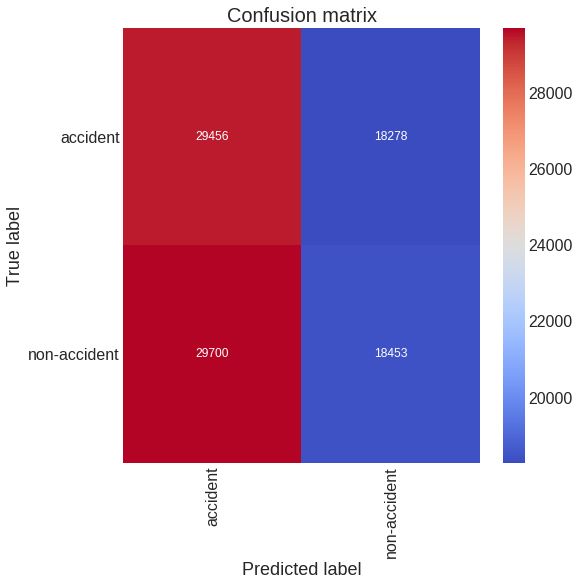

In [105]:
cnf_mx = confusion_matrix(y_test,y_pred,labels=y.unique())
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

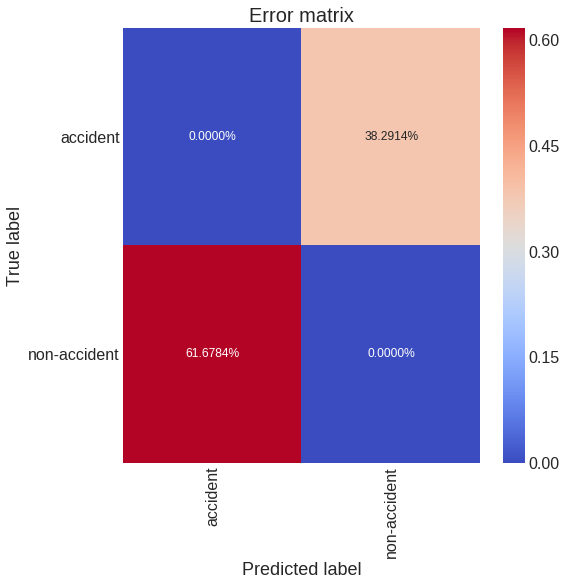

In [106]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".4%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

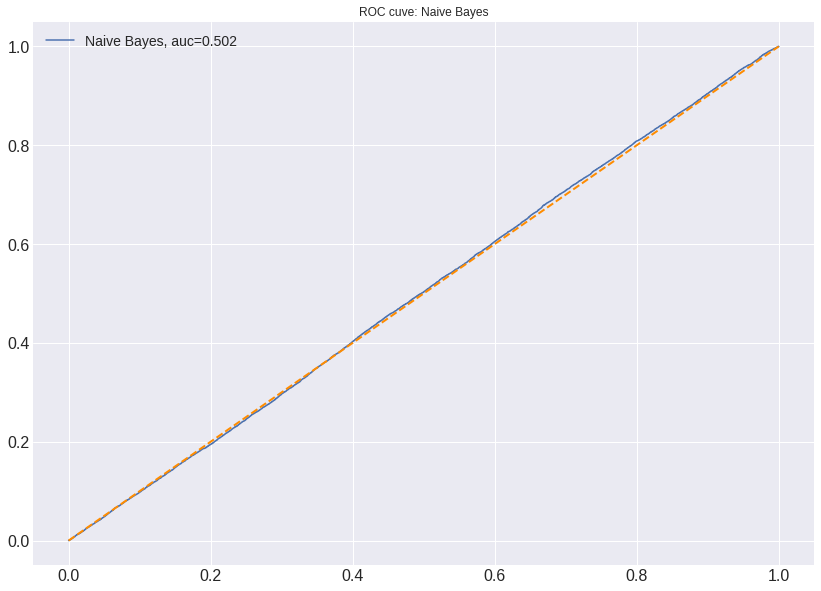

0.5023

In [107]:
roc_curve(clf3.predict_proba(X_test)[:,1], y_test, "Naive Bayes")

### Categorical weather covariates. Balanced Classes

In [108]:
feature_selection_2 = ['x', 'y', 'day_of_year', 'hour',
       'cluster_id', 'population_density', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain']